In [12]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import os
import json


In [10]:
# Abre el archivo GeoTIFF
dataset = rasterio.open('..\\data\\Zona\\of5mtif1678296896753.tif')

# Imprime información sobre el archivo
print(f'Número de bandas: {dataset.count}')
print(f'Tamaño del archivo: {dataset.width}x{dataset.height}')
print(f'Sistema de coordenadas: {dataset.crs}')

Número de bandas: 3
Tamaño del archivo: 13734x13638
Sistema de coordenadas: EPSG:25831


In [2]:
def image_to_window(coordenadas_image, coordenadas_window, transform, shape):
    xmin, ymin, xmax, ymax = coordenadas_image
    xmin_window, ymin_window = coordenadas_window
    len_y, len_x, len_z = shape

    # Ajusta las posiciones de los rectángulos a la ventana
    xmin, ymin, xmax, ymax = xmin - xmin_window, ymin - ymin_window, xmax - xmin_window, ymax - ymin_window
    
    # Escala las posiciones a la resolución de la imagen
    xmin, ymin, xmax, ymax = xmin / transform.a, ymin / transform.a, xmax / transform.a, ymax / transform.a

    # Invierte las coordenadas en el eje y
    ymin, ymax = len_y - ymax, len_y - ymin

    return int(xmin), int(ymin), int(xmax), int(ymax)

def window_to_image(coordenadas_image, coordenadas_window, transform, shape):
    xmin, ymin, xmax, ymax = coordenadas_image
    xmin_window, ymin_window = coordenadas_window
    len_y, len_x, len_z = shape

    # Invierte las coordenadas en el eje y
    ymin, ymax = len_y - ymax, len_y - ymin

    # Escala las posiciones a la resolución de la imagen
    xmin, ymin, xmax, ymax = xmin * transform.a, ymin * transform.a, xmax * transform.a, ymax * transform.a

    # Ajusta las posiciones de los rectángulos a la ventana
    xmin, ymin, xmax, ymax = xmin - xmin_window, ymin - ymin_window, xmax - xmin_window, ymax - ymin_window
    
    return int(xmin), int(ymin), int(xmax), int(ymax)

def xyxy_to_cxcywh(coordenadas):
    xmin, ymin, xmax, ymax = coordenadas
    x = (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    w = xmax - xmin
    h = ymax - ymin
    return x, y, w, h

def cxcywh_to_xyxy(coordenadas):
    x, y, w, h = coordenadas
    xmin = x - w / 2
    ymin = y - h / 2
    xmax = x + w / 2
    ymax = y + h / 2
    return xmin, ymin, xmax, ymax

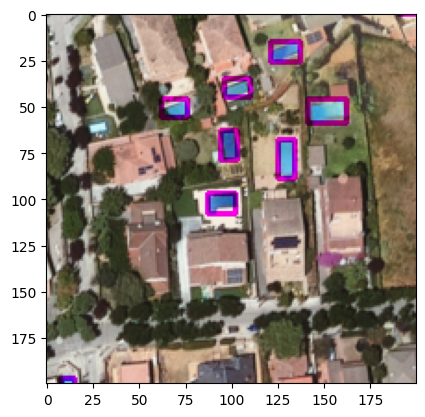

In [7]:
# Lee el archivo shapefile
regions = gpd.read_file('..\\data\\Zona\\clean\\bt5mv20sh0f286122hp1r060.shp')

xmin_window, ymin_window, xmax_window, ymax_window = 420660, 4590892, 420660+100, 4590892+100

# Recorta el GeoTIFF según las coordenadas de la window
window = rasterio.windows.from_bounds(xmin_window, ymin_window, xmax_window, ymax_window, dataset.transform)
clipped_data = dataset.read(window=window)
clipped_data = np.moveaxis(clipped_data, 0, -1)

# Muestra todas las regiones de interés en la window
for region in regions.geometry:
    xmin, ymin, xmax, ymax = region.bounds

    xmin, ymin, xmax, ymax = image_to_window((xmin, ymin, xmax, ymax), (xmin_window, ymin_window), dataset.transform, clipped_data.shape)

    # Dibuja los rectángulos
    cv2.rectangle(clipped_data[:, :, 1], (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)

# Visualiza la ventana con los rectángulos
plt.imshow(clipped_data)
plt.show()

In [37]:
list_regions = []
for file in os.listdir("..\data\Zona\clean"):
    if file.endswith(".shp"):
        regions = gpd.read_file(f'..\\data\\Zona\\clean\\{file}')
        list_regions.append(regions)

# find global xmin, ymin, xmax, ymax
xmin_total, ymin_total, xmax_total, ymax_total = 10**10, 10**10, 0, 0
for regions in list_regions:
    for region in regions.geometry:
        xmin, ymin, xmax, ymax = region.bounds
        xmin_total = min(xmin_total, xmin)
        ymin_total = min(ymin_total, ymin)
        xmax_total = max(xmax_total, xmax)
        ymax_total = max(ymax_total, ymax)
        
xmin_total, ymin_total, xmax_total, ymax_total = int(xmin_total), int(ymin_total), int(xmax_total), int(ymax_total)

print(xmin_total, ymin_total, xmax_total, ymax_total)
print(xmax_total - xmin_total, ymax_total - ymin_total)

418251 4590058 425216 4596979
6965 6921


In [40]:
(xmax_total - xmin_total)/500 * (ymax_total - ymin_total)/500

192.81906

In [33]:
50*50*3

7500

In [41]:
random.seed(0)
Ninf = 50
Nsup = 100
n_image = 0
n_total = 0

N = 500
step = 250
annotations = []
for step_x in range(N, xmax_total - xmin_total, step):
    for step_y in range(N, ymax_total - ymin_total, step):
        n_id = 0
        xmin, ymin, xmax, ymax = region.bounds

        xmin_window = xmin_total + step_x - N
        ymin_window = ymin_total + step_y - N
        xmax_window = xmin_total + step_x
        ymax_window = ymin_total + step_y


        # Recorta el GeoTIFF según las coordenadas de la window
        window = rasterio.windows.from_bounds(xmin_window, ymin_window, xmax_window, ymax_window, dataset.transform)
        clipped_data = dataset.read(window=window)
        clipped_data = np.moveaxis(clipped_data, 0, -1)

        # Muestra todas las regiones de interés en la window
        for regions2 in list_regions:
            for region2 in regions2.geometry:
                xmin, ymin, xmax, ymax = region2.bounds
                # if region in window
                if xmin > xmin_window and ymin > ymin_window and xmax < xmax_window and ymax < ymax_window:
                    annotation = dict()
                    annotation['category_id'] = 0
                    annotation['id_of_image'] = n_image
                    annotation['id_in_image'] = n_id
                    annotation['id_total'] = n_total
                    annotation['bbox'] = xyxy_to_cxcywh(region2.bounds)
                    annotation['segmentation'] = [(x, y) for x, y in zip(region2.exterior.coords.xy[0], region2.exterior.coords.xy[1])]
                    n_id += 1
                    n_total += 1
                    annotations.append(annotation)

        if n_id != 0:
            # Guarda la imagen con nombre "n_image"_"numero de regiones en la imagen".jpg
            cv2.imwrite(f'..\\data\\Zona\\Dataset\\images\\{n_image}_{n_id}.jpg', cv2.cvtColor(clipped_data, cv2.COLOR_RGB2BGR))
            n_image += 1

with open('..\\data\\Zona\\Dataset\\annotations\\annotations.json', 'w') as f:
    json.dump(annotations, f)